In [1]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from style_utils import load_vgg_model, load_and_preprocess_images, GramMatrix, weighted_style_correlation
import tifffile as tiff
from PIL import Image
import matplotlib.ticker as ticker
import pandas as pd

# Constants
model_path = "/home/idies/workspace/Storage/xyu1/persistent/micro-sam/finetuning/PytorchNeuralStyleTransfer/Models/vgg_conv.pth"
style_layers = ['r11','r21','r31','r41', 'r51']
style_weights = [1.0] * len(style_layers)

# Paths to image folders (each should have subfolders: images/, masks/)
dataset_folders = {
    "LiveCELL": {
        "val": "/home/idies/workspace/Temporary/xyu1/scratch/cellpose_subset/livecell/val/images",
        "test": "/home/idies/workspace/Temporary/xyu1/scratch/cellpose_subset/livecell/test/images"
    },
    "TissueNet": {
        "val": "/home/idies/workspace/Temporary/xyu1/scratch/cellpose_subset/tissuenet/slices/multi_chan/val/images",
        "test": "/home/idies/workspace/Temporary/xyu1/scratch/cellpose_subset/tissuenet/slices/multi_chan/test/images"
    },
    "PlantSeg": {
        "val": "/home/idies/workspace/Temporary/xyu1/scratch/cellpose_subset/plantseg/root/val/images",
        "test": "/home/idies/workspace/Temporary/xyu1/scratch/cellpose_subset/plantseg/root/test/images"
    },
    "Lizard": {
        "val": "/home/idies/workspace/Temporary/xyu1/scratch/cellpose_subset/lizard/val/images",
        "test": "/home/idies/workspace/Temporary/xyu1/scratch/cellpose_subset/lizard/test/images"
    }
}

dataset_folders_for_test = {
    "combined_dataset": {
        "test": "/home/idies/workspace/Temporary/xyu1/scratch/cellpose_subset/combined_dataset_new/test/images"
    }
}

# === FUNCTIONS ===
def extract_features(image_path, vgg, style_layers):
    img_name = os.path.basename(image_path)
    image_tensor = load_and_preprocess_images(os.path.dirname(image_path) + "/", [img_name])[0]
    features = [GramMatrix()(f).detach() for f in vgg(image_tensor, style_layers)]
    return features

# Draw dataset split lines
def draw_split_lines(ax, labels, axis='x'):
    positions = []
    prev = labels[0]
    for i, label in enumerate(labels):
        if label != prev:
            positions.append(i)
            prev = label
    for p in positions:
        if axis == 'x':
            ax.axvline(p, color='white', linestyle='--')
        elif axis == 'y':
            ax.axhline(p, color='white', linestyle='--')
# === MAIN PIPELINE ===

# Load model
vgg = load_vgg_model(model_path)

# Accumulate features
all_val_features, all_test_features = [], []
val_dataset_labels, test_dataset_labels = [], []
val_image_indices, test_image_indices = [], []

val_count = test_count = 0

for dataset, paths in dataset_folders.items():
    val_paths = sorted([
        os.path.join(paths["val"], f) for f in os.listdir(paths["val"])
        if f.lower().endswith((".tif", ".tiff", ".png", ".jpg"))
    ])
    test_paths = sorted([
        os.path.join(paths["test"], f) for f in os.listdir(paths["test"])
        if f.lower().endswith((".tif", ".tiff", ".png", ".jpg"))
    ])

    print(f"{dataset}: {len(val_paths)} val, {len(test_paths)} test images")

    for p in val_paths:
        features = extract_features(p, vgg, style_layers)
        if features:
            all_val_features.append(features)
            val_dataset_labels.append(dataset)
            val_image_indices.append(val_count)
            val_count += 1

    for p in test_paths:
        features = extract_features(p, vgg, style_layers)
        if features:
            all_test_features.append(features)
            test_dataset_labels.append(dataset)
            test_image_indices.append(test_count)
            test_count += 1

# Compute similarity matrix
print("Computing style correlations...")
similarity_matrix = np.zeros((len(all_test_features), len(all_val_features)))

for i, test_f in enumerate(all_test_features):
    for j, val_f in enumerate(all_val_features):
        similarity_matrix[i, j] = weighted_style_correlation(val_f, test_f, style_weights)

LiveCELL: 8 val, 80 test images
TissueNet: 10 val, 100 test images
PlantSeg: 10 val, 100 test images
Lizard: 5 val, 80 test images
Computing style correlations...


/tmp/ipykernel_37641/577781402.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


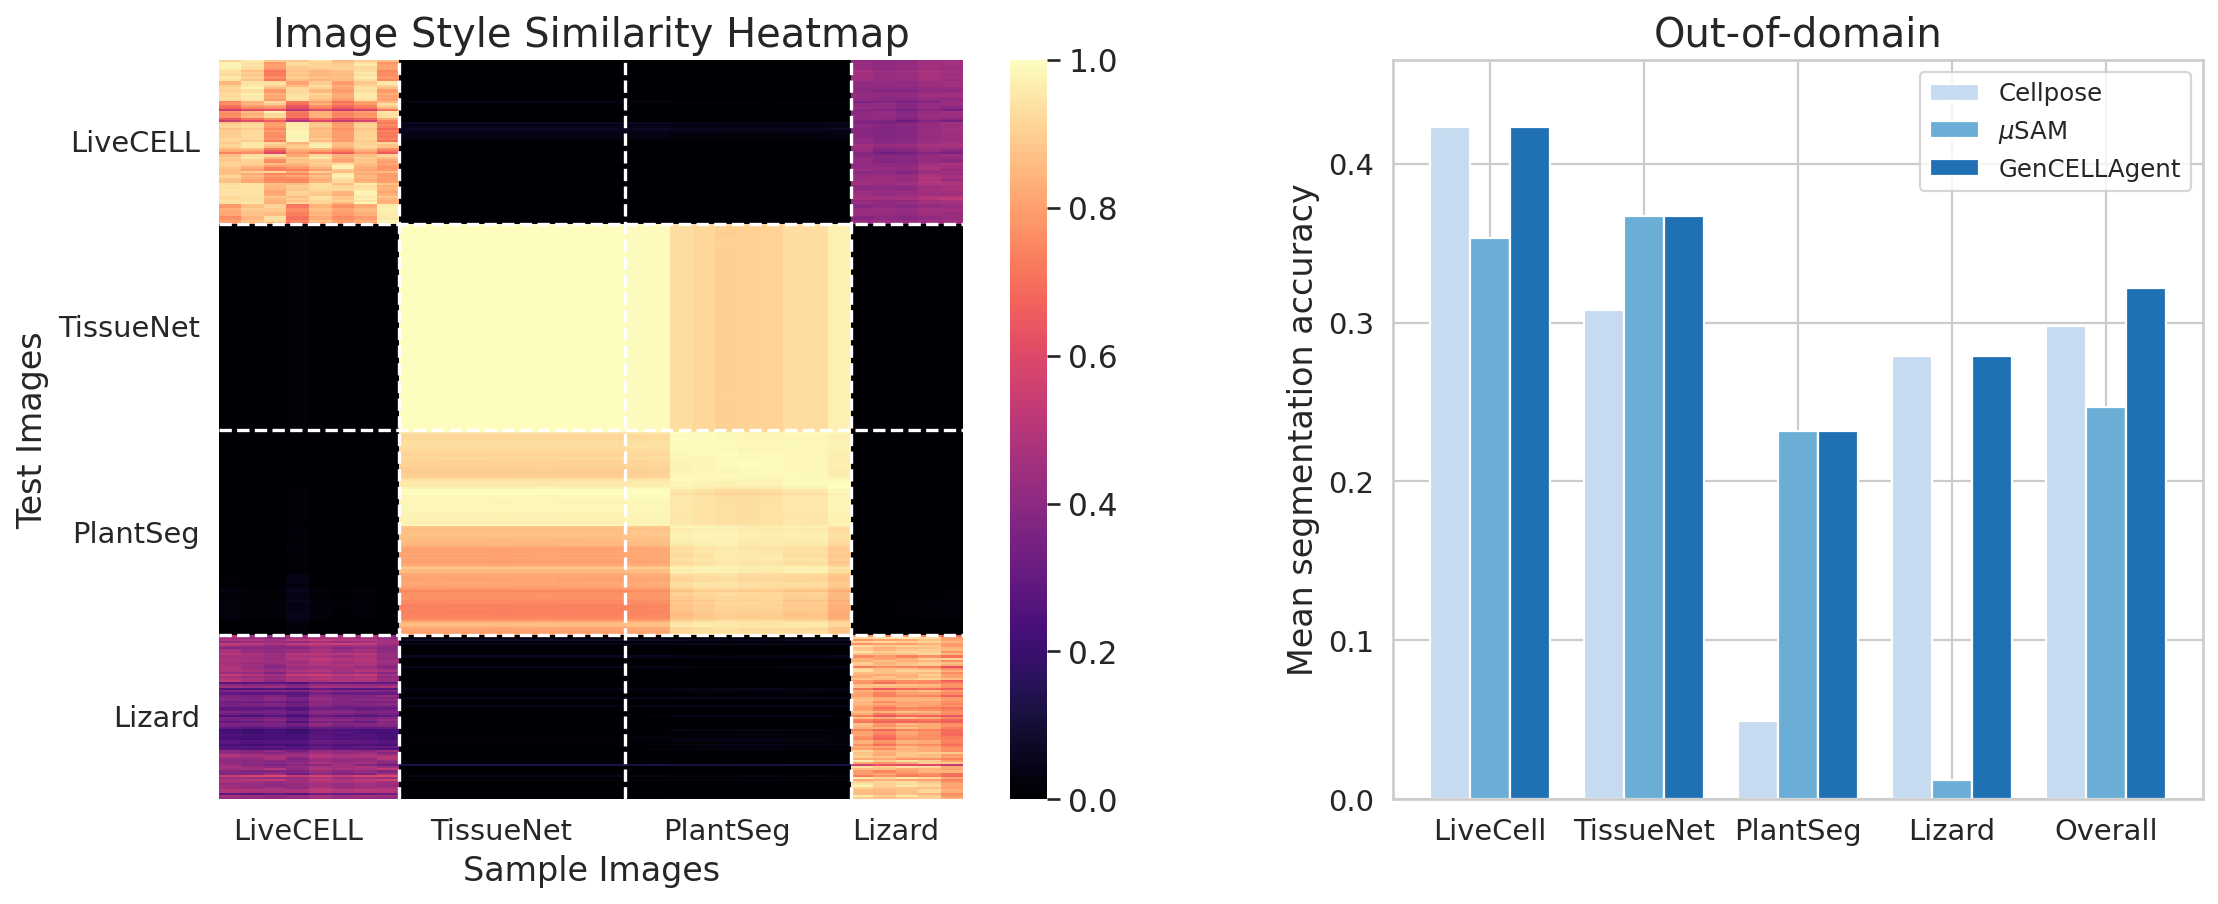

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np

# ====== your data ======
# Heatmap expects: similarity_matrix, val_dataset_labels, test_dataset_labels
# and a function draw_split_lines(ax, labels, axis='x'|'y') already defined.

# Bar data you provided:
categories = ["LiveCell", "TissueNet", "PlantSeg", "Lizard", "Overall"]
means_cellpose = np.array([0.423, 0.308, 0.049, 0.279, 0.298])
means_usam     = np.array([0.353, 0.367, 0.232, 0.012, 0.247])  # micro_sam
means_ours     = np.array([0.423, 0.367, 0.232, 0.279, 0.322])  # Ours

# ====== helpers ======
def compute_label_positions(labels):
    positions = []
    current = labels[0]
    start_idx = 0
    for i, label in enumerate(labels):
        if label != current:
            mid = (start_idx + i - 1) / 2
            positions.append((mid, current))
            start_idx = i
            current = label
    mid = (start_idx + len(labels) - 1) / 2
    positions.append((mid, current))
    return positions

# ====== styling ======
BASE_FONTSIZE = 14
TITLE_FONTSIZE = 18
LABEL_FONTSIZE = 15
TICK_FONTSIZE = 13
CBAR_TICK_FONTSIZE = 14
CBAR_LABEL_FONTSIZE = 16

sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "figure.dpi": 160,
    "axes.titlesize": TITLE_FONTSIZE,
    "axes.labelsize": LABEL_FONTSIZE,
    "xtick.labelsize": TICK_FONTSIZE,
    "ytick.labelsize": TICK_FONTSIZE,
    "axes.linewidth": 1.2,
})

HEATMAP_CMAP = "magma"                 # warm, high-contrast
#bar_colors = sns.color_palette("flare", 3)  # warm sequence for bars
# ====== palettes ======
#HEATMAP_CMAP = "Blues"  # keep warm heatmap
# Blue-warm palette for bars
bar_colors = sns.color_palette("Blues", 3)   # lighter to darker blues

# ====== figure layout ======
fig = plt.figure(figsize=(16, 6))
gs = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[1.15, 1], wspace=0.28)

# ---------- Left: Heatmap ----------
ax_hm = fig.add_subplot(gs[0, 0])
hm = sns.heatmap(
    similarity_matrix,
    cmap=HEATMAP_CMAP,
    vmin=0.0,
    vmax=1.0,
    xticklabels=False,
    yticklabels=False,
    cbar=True,
    ax=ax_hm
)

ax_hm.set_title("Image Style Similarity Heatmap")
ax_hm.set_xlabel("Sample Images")
ax_hm.set_ylabel("Test Images")

# dashed block boundaries
draw_split_lines(ax_hm, val_dataset_labels, axis='x')
draw_split_lines(ax_hm, test_dataset_labels, axis='y')

# dataset group labels
x_labels = compute_label_positions(val_dataset_labels)
ax_hm.xaxis.set_major_locator(ticker.FixedLocator([p[0] for p in x_labels]))
ax_hm.set_xticklabels([p[1] for p in x_labels], rotation=0, fontsize=TICK_FONTSIZE)

y_labels = compute_label_positions(test_dataset_labels)
ax_hm.yaxis.set_major_locator(ticker.FixedLocator([p[0] for p in y_labels]))
ax_hm.set_yticklabels([p[1] for p in y_labels], rotation=0, fontsize=TICK_FONTSIZE)

# colorbar styling
cbar = hm.collections[0].colorbar
cbar.ax.tick_params(labelsize=CBAR_TICK_FONTSIZE, width=1.2)


ax_hm.tick_params(width=1.2, length=5)

# ---------- Right: Bar chart ----------
ax_bar = fig.add_subplot(gs[0, 1])
ax_bar.set_title("Out-of-domain")

x = np.arange(len(categories))
width = 0.26

ax_bar.bar(x - width, means_cellpose, width, label="Cellpose", color=bar_colors[0])
ax_bar.bar(x,          means_usam,    width, label="$μ$SAM",     color=bar_colors[1])
ax_bar.bar(x + width,  means_ours,    width, label="GenCELLAgent",     color=bar_colors[2])

ax_bar.set_ylabel("Mean segmentation accuracy")
ax_bar.set_xticks(x, categories)

ymax = max(means_cellpose.max(), means_usam.max(), means_ours.max())
ax_bar.set_ylim(0, max(0.45, 1.1 * ymax))

# ✅ Legend placed inside the plot (top-right corner)
ax_bar.legend(
    frameon=True,       # show small box around legend
    fontsize=11,
    loc="upper right"   # try 'upper left', 'lower right', etc. if you prefer
)

ax_bar.tick_params(width=1.2, length=5)

# Closed box around chart
for spine in ["top", "right", "left", "bottom"]:
    ax_bar.spines[spine].set_visible(True)
    ax_bar.spines[spine].set_linewidth(1.2)

plt.tight_layout()
plt.savefig("Fig_results.pdf", bbox_inches="tight", pad_inches=0.1, format="pdf")
plt.show()


In [8]:
#save model selection resutls based on the similairty

dataset_folders_for_test = {
    "combined_dataset": {
        "test": "/home/idies/workspace/Temporary/xyu1/scratch/cellpose_subset/combined_dataset_new/test/images"
    }
}

# Step 1: Load all val features and labels
all_val_images = []
all_val_features = []
val_dataset_labels = []

for dataset, paths in dataset_folders.items():
    val_images = sorted([
        os.path.join(paths["val"], f)
        for f in os.listdir(paths["val"]) if f.endswith((".tif", ".tiff", ".png", ".jpg"))
    ])
    all_val_images.extend(val_images)
    val_dataset_labels.extend([dataset] * len(val_images))
    all_val_features.extend([extract_features(img, vgg, style_layers) for img in val_images])

dataset_names = list(dataset_folders.keys())

# Step 2: Load test features from new dataset
all_test_images = []
all_test_features = []

for _, paths in dataset_folders_for_test.items():
    test_images = sorted([
        os.path.join(paths["test"], f)
        for f in os.listdir(paths["test"]) if f.endswith((".tif", ".tiff", ".png", ".jpg"))
    ])
    all_test_images.extend(test_images)
    all_test_features.extend([extract_features(img, vgg, style_layers) for img in test_images])

# Step 3: Compute similarity scores (test × val)
num_test = len(all_test_features)
num_val = len(all_val_features)
scores = np.zeros((num_test, num_val))

for i, test_feat in enumerate(all_test_features):
    for j, val_feat in enumerate(all_val_features):
        scores[i, j] = weighted_style_correlation(test_feat, val_feat, style_weights)

# Step 4: Group val features by dataset and average
compressed_scores = np.zeros((num_test, len(dataset_names)))

for dataset_idx, dataset in enumerate(dataset_names):
    val_indices = [i for i, label in enumerate(val_dataset_labels) if label == dataset]
    compressed_scores[:, dataset_idx] = scores[:, val_indices].mean(axis=1)
    

# Create DataFrame
df = pd.DataFrame(
    compressed_scores,
    columns=dataset_names,
    index=[os.path.basename(p) for p in all_test_images]
)

# Move index to column
df.index.name = "image_name"
df.reset_index(inplace=True)

# Save to CSV
output_path = "model_selection.csv"
df.to_csv(output_path, index=False)


# Define exact model names for each dataset
model_map = {
    "LiveCELL": "cellpose_livecell",
    "TissueNet": "micro_sam_TissueNet",
    "PlantSeg": "micro_sam_plantseg",
    "Lizard": "cellpose_lizard"
}

# Function to select model with max correlation from other datasets
def select_model(row):
    image_name = str(row["image_name"])
    target_dataset = image_name.split("_")[0]
    other_datasets = [ds for ds in model_map if ds != target_dataset]
    max_dataset = row[other_datasets].idxmax()
    return model_map[max_dataset]

# Apply model selection
df["selected_model"] = df.apply(select_model, axis=1)

# Save the results to CSV
df.to_csv(output_path, index=False)

print(f"Model selection saved to: {output_file}")